In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tree_util


In [2]:
frac_df = pd.read_csv('../data/FMT/FMT2/Eric.txt', sep='\t', header=0, index_col=0)
deltat = pd.read_csv('../data/FMT/FMT2/deltat.txt', sep='\t', header=0, index_col=0)
triads = pd.read_csv('../data/FMT/FMT2/triads.txt', sep='\t', header=0, index_col=None)

In [3]:
for idx in triads.index:
    posts = triads.loc[idx, 'post_samples'].strip().split(',')
    times = []
    for p in posts:
        if p not in deltat.index:
            print(p)
        else:
            times.append(str(deltat.loc[p, 'delta_t']))
    t_str = ','.join(times)
    triads.loc[idx, 'days'] = t_str

In [4]:
for idx in frac_df.index:
    d = frac_df.loc[idx, 'Days postFMT']
    cand = triads[triads['days'] == d]['pre_sample']
    ids = triads[triads['days'] == d].index
    if len(cand) == 1:
        #print(list(cand))
        s = list(cand)[0]
        frac_df.loc[idx, 'sname'] = s
        triads.loc[list(ids)[0], 'alias'] = idx
triads.loc[10, 'alias'] = 'FMT5' 
s = triads.loc[10, 'pre_sample']
frac_df.loc['FMT5', 'sname'] = s

In [5]:
def fr(d_df, profile, sname):
    sp_list = list(profile.columns)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    df = pd.DataFrame(data= value, index=sp_list, columns=sp_list)
    return df

def nfr(d_df, profile, sname):
    sp_list = list(profile.columns)
    n = len(sp_list)
    corr = np.ones(shape=(n, n)) - d_df.loc[sp_list, sp_list].values
    np.fill_diagonal(corr, 0)
    # print(corr[1, 1])
    a = np.array(profile.loc[sname, sp_list])
    inter_matrix = np.dot(a.reshape(len(a), 1),a.reshape(1, len(a)))
    np.fill_diagonal(inter_matrix, 0)
    td = np.sum(inter_matrix)/2
    fr = np.sum(np.multiply(inter_matrix, corr))/2
    fd = np.sum(np.multiply(inter_matrix, d_df.loc[sp_list, sp_list].values))/2
    if td == 0:
        return 0
    return fr, td, fd

def multisample_nfr(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    result2 = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    result3 = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys()) + ['nroot']))
    for sname in profile.index:
       for node, sp_list in node_leaves.items():
           sp_list = list(set(sp_list).intersection(set(profile.columns)))
           selected_d = d_df.loc[sp_list, sp_list]
           selected_profile = profile.loc[:, sp_list]
           value, td, fd = nfr(selected_d, selected_profile, sname)
           result.loc[sname, node] = value
           result2.loc[sname, node] = td
           result3.loc[sname, node] = fd
    return result, result2, result3

In [6]:
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()
    # newick_tree = newick_tree.replace('-', '_')

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
leaves_dict = copy.deepcopy(layer_leaves_dict)

parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

In [7]:
outdir = '../result/FMT/FR/FMT2_root'
if not os.path.exists(outdir):
    os.makedirs(outdir)
param = 0.5
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
abd = pd.read_csv('../data/FMT/FMT2/Eric_abd.tsv', sep='\t', header=0, index_col=0)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
d_df = d_df.rename(columns=name_dict, index=name_dict)
abd = abd.rename(columns=name_dict)
profile = abd[list(set(abd.columns).intersection(set(d_df.columns)))]
profile = profile.div(profile.sum(axis=1), axis=0)

profile = profile.rename(index={'FMT5':'FMT05'})
pre_slist = list(frac_df['sname'])
profile = profile.loc[pre_slist,]
rename_dict = {}
for idx in frac_df.index:
    rename_dict[frac_df.loc[idx, 'sname']] = idx
profile.rename(index=rename_dict).to_csv(os.path.join(outdir, 'abd.tsv'), sep='\t')

In [8]:
node_leaves = {'root': leaf_list}
se_df, se_df2, se_df3 = multisample_nfr(profile, d_df, node_leaves)
se_df = se_df.T
se_df = se_df.drop('nroot')
se_df2 = se_df2.drop('nroot', axis=1)
se_df3 = se_df3.drop('nroot', axis=1)
se_df.to_csv(os.path.join(outdir, 'fr.tsv'), sep='\t')
se_df2.to_csv(os.path.join(outdir, 'td.tsv'), sep='\t')
se_df3.to_csv(os.path.join(outdir, 'fd.tsv'), sep='\t')
se_dict = {'fr': se_df, 'td': se_df2.T, 'fd': se_df3.T}

In [9]:
p_cutoff = 0.05
# compute frac and t
frac = []
t = []
sname_list = []
for idx in frac_df.index:
    sname = frac_df.loc[idx, 'sname']
    t_str = frac_df.loc[idx, 'Days postFMT']
    frac_str = frac_df.loc[idx, 'Fraction of donor specific strains']
    t += [int(ts) for ts in t_str.split(',')]
    frac += [float(f) for f in frac_str.split(',')]
    sname_list += [sname]*len(t_str.split(','))


In [10]:
elist = ['td', 'fd', 'fr']
e_dict = {}
for e in elist:
    e_dict[e] = pd.DataFrame(columns=['F-pvalue', '{}_co'.format(e), 't_co', 'const_co', '{}_p'.format(e), 't_p', 'const_p'])
for node in node_leaves.keys():
    se = []
    td = []
    fd = []
    for sname in sname_list:
        value = se_df.loc[node, sname]
        se.append(value)
        td.append(se_df2.loc[sname, node])
        fd.append(se_df3.loc[sname, node])
    if sum(se) == 0:
        continue
    df = pd.DataFrame()
    df['frac'] = frac
    df['fr'] = se
    df['fd'] = fd
    df['td'] = td
    df['t'] = t
    
    for e in elist:
        X = df[[e, 't']]
        y = df['frac']
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        result = model.fit()
        
        e_dict[e].loc[node, 'F-pvalue'] = result.f_pvalue
        for var in result.pvalues.index:
            e_dict[e].loc[node, "{}_co".format(var)] = result.params[var]
            e_dict[e].loc[node, "{}_p".format(var)] = result.pvalues[var]
for e, odf in e_dict.items():
    odf.sort_values(by='F-pvalue').to_csv(os.path.join(outdir, '{}_p_values.tsv'.format(e)), index=True, header=True, sep='\t')

In [11]:
for e, odf in e_dict.items():
    print(odf[odf['F-pvalue']<p_cutoff])

Empty DataFrame
Columns: [F-pvalue, td_co, t_co, const_co, td_p, t_p, const_p]
Index: []
Empty DataFrame
Columns: [F-pvalue, fd_co, t_co, const_co, fd_p, t_p, const_p]
Index: []
Empty DataFrame
Columns: [F-pvalue, fr_co, t_co, const_co, fr_p, t_p, const_p]
Index: []


<ipython-input-12-f14c74456b7c>:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-12-f14c74456b7c>:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-12-f14c74456b7c>:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


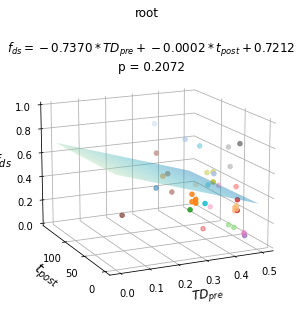

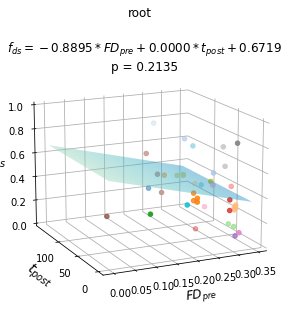

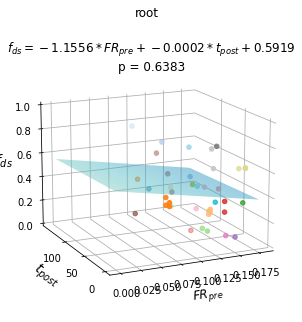

In [12]:
elist = ['td', 'fd', 't']
for e, odf in e_dict.items():
    formula_tmp = r'$f_{{ds}} = {:.4f}*{}_{{pre}} + {:.4f}*t_{{post}} + {:.4f}$' + '\np = {:.4}'
    for node in sorted(list(odf.index)):
        se_co = odf.loc[node, '{}_co'.format(e)]
        t_co = odf.loc[node, 't_co']
        const = odf.loc[node, 'const_co']
        p_value = odf.loc[node, 'F-pvalue']
        se = np.linspace(0, max(max(se_dict[e].loc[node, ])*1.1, 0.05), 1000)
        t = np.linspace(0, 150, 1000)
        X, Y = np.meshgrid(se, t)
        f = se_co*X + t_co*Y + const
        f[f>1] = np.nan
        f[f<0] = np.nan
        formula = formula_tmp.format(se_co, e.upper(), t_co, const, p_value)
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='3d')
        cmp = plt.cm.YlGnBu_r
        surf = ax.plot_surface(X, Y, f, cmap=cmp, alpha=0.5)
        surf.set_clim(0, 1)
        ax.set_yticks(np.arange(0, 150, 50))
        ax.set_yticklabels(np.arange(0, 150, 50))

        ax.set_zlim((0, 1))
        ax.set_zticks(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]))
        ax.set_zticklabels(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]))

        #ax.set_xticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 25]))
        #ax.set_xticklabels(np.array([0, 0.05, 0.1, 0.15, 0.2, 25]))
        ax.set_xlabel(r'${}_{{pre}}$'.format(e.upper()), fontweight='bold', fontsize=12)
        ax.set_ylabel(r'$t_{post}$', fontweight='bold', fontsize=14)
        ax.zaxis.set_rotate_label(False) 
        ax.set_zlabel(r'$f_{ds}$', fontweight='bold', fontsize=14)

        se = []
        frac = []
        t = []
        colors = []
        slist = []
        for sname in frac_df.index:
            sname2 = frac_df.loc[sname, 'sname']
            t_str = frac_df.loc[sname, 'Days postFMT']
            frac_str = frac_df.loc[sname, 'Fraction of donor specific strains']
            n_t = len(t_str.split(','))
            t += [int(ts) for ts in t_str.split(',')]
            frac += [float(f) for f in frac_str.split(',')]
            #c += [color_dict[int(sname[3:])]] * n_t
            colors += [int(sname[3:])-1] * n_t
            se += [se_dict[e].loc[node, sname2]] * n_t
            slist += [sname] * n_t

        point_df = pd.DataFrame(columns=['sample', '{}_pre'.format(e), 't_post', 'f_ds'])
        point_df['sample'] = slist
        point_df['{}_pre'.format(e)] = se
        point_df['t_post'] = t
        point_df['f_ds'] = frac

        point_df.to_csv(os.path.join(outdir, '{}_{}.tsv'.format(e, node)), sep='\t', header=True, index=False)
        #print(se)
        ax.scatter(se, t, frac, c = colors, cmap='tab20')
        ax.view_init(elev=15, azim=245)
        ax.set_title(formula, y = 0.95)
        ax.xaxis.set_pane_color((1, 1, 1, 1))
        ax.yaxis.set_pane_color((1, 1, 1, 1))
        ax.zaxis.set_pane_color((1, 1, 1, 1))
        plt.suptitle(node.replace('_', ' '))
        # fig.colorbar(surf)
        plt.tight_layout()
        opath = os.path.join(outdir, '{}_{}.svg'.format(e, node))
        plt.savefig(opath, dpi=300, format='svg')
        # plt.show()